In [1]:
%load_ext autoreload
%autoreload 2


In [91]:
import numpy as np
import clmm
import matplotlib.pyplot as plt
from data_functions import *
from model_functions import _delta_sigma_4theta, _delta_sigma_const, _delta_sigma_excess
from clmm import Cosmology
import scipy
from scipy.optimize import minimize

In [43]:
cosmo = Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

r_proj = np.linspace(0.1,1.0,1000)
mdelta=10E14
cdelta=4.0
z_cl=0.3
sigma = clmm.compute_surface_density(r_proj, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model='nfw', massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)


In [44]:
q=2/3
ell = (1-q**2)/(1+q**2)
r_ = np.logspace(-1,1,100)*0.7

mdelta=2*1E14
delta_mdef = 200
cdelta=3.89
z_cl=0.8

rdelta = (mdelta/((4*np.pi/3)*cosmo.get_rho_m(z_cl)*delta_mdef))**(1/3)
rs=rdelta/cdelta

ds4theta, eta_func = _delta_sigma_4theta(ell, r_, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000)
dsconst, eta_func = _delta_sigma_const(ell, r_, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000)

In [45]:
g_t_monopole = gamma_tangential_monopole(r_proj, mdelta, cdelta, z_cl, cosmo, hpmd='nfw')

In [46]:
sigma_crit = 3.77988e+15

In [81]:
gamma1 = np.hstack(np.load("gamma1.npy") * -1)
gamma2 = np.hstack(np.load("gamma2.npy") * -1)

gammat = np.hstack(np.load("gamma_T.npy") * -1)
gammax = np.hstack(np.load("gamma_X.npy") * -1)


x_arcsec = np.hstack(np.load("x_arcsec.npy"))
y_arcsec = np.hstack(np.load("y_arcsec.npy"))


In [65]:
Nbins = 25
arcsec_to_Mpc = 0.00588784182755241
r, rbin_edges, r_bins, r_inds = make_radial_bins(x_arcsec*arcsec_to_Mpc, y_arcsec*arcsec_to_Mpc, Nbins)
theta = calc_theta(x_arcsec, y_arcsec)

delta_sigmas_4theta = []
delta_sigmas_const = []
delta_sigmas_4theta_cross = []
delta_sigmas_const_cross = []
for i in range(Nbins):
    select = (r_inds == i) #& (r>=0.1)
    theta_i = theta[select]
    gamma1_i = gamma1[select]
    gamma2_i = gamma2[select]
    w_i, w1_i, w2_i = weights(sigma_crit, theta_i)
    DS4thetai = Delta_Sigma_4theta(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_crit)
    DSconsti = Delta_Sigma_const(w_i, gamma1_i, sigma_crit)
    DS4thetacrossi = Delta_Sigma_4theta_cross(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_crit)
    DSconstcrossi = Delta_Sigma_const_cross(w_i, gamma2_i, sigma_crit)
    delta_sigmas_4theta.append([np.mean(DS4thetai), np.std(DS4thetai)/np.sqrt(len(DS4thetai))])
    delta_sigmas_const.append([np.mean(DSconsti), np.std(DSconsti)/np.sqrt(len(DSconsti))])
    delta_sigmas_4theta_cross.append([np.mean(DS4thetacrossi), np.std(DS4thetacrossi)/np.sqrt(len(DS4thetacrossi))])
    delta_sigmas_const_cross.append([np.mean(DSconstcrossi), np.std(DSconstcrossi)/np.sqrt(len(DSconstcrossi))])

In [171]:
def MLE(B,x,y1,dy1, y2, dy2) :
    ## B = [ellipticity, log_mdelta, cdelta,]
    yPred1 = _delta_sigma_4theta(B[0], x, 10**B[1], B[2], z_cl, cosmo=cosmo, hpmd='nfw', sample_N=1000)[0]
    s1 = dy1**2 + yPred1**2*np.exp(2*B[3])
    yPred2 = _delta_sigma_const(B[0], x, 10**B[1], B[2], z_cl, cosmo=cosmo, hpmd='nfw', sample_N=1000)[0]
    s2 = dy2**2 + yPred2**2*np.exp(2*B[4])
    negLL = -np.sum(-(y1-yPred1)**2/2/s1 - np.log(2*np.pi*s1)/2) - np.sum(-(y2-yPred2)**2/2/s2 - np.log(2*np.pi*s2)/2)
    return negLL

In [134]:
order = np.isfinite(r_bins) & (r_bins >= rs)
results = minimize(MLE, [0,15,1, 0.1, 0.1],# method='BFGS',
                   args=(r_bins[order], np.array(delta_sigmas_4theta)[:,0][order], np.array(delta_sigmas_4theta)[:,1][order],
                         np.array(delta_sigmas_const)[:,0][order], np.array(delta_sigmas_const)[:,1][order]), bounds=((0,1),(12,17),(1,20),(-10,0),(-10,0)))
results

      fun: 870.4374610094445
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.03886953, -0.04509956,  0.00449063,  0.00044338, -0.00109139])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 330
      nit: 37
     njev: 55
   status: 0
  success: True
        x: array([ 0.49245355, 14.03146568,  4.03312683, -6.70195922, -0.68264431])

In [136]:
# np.sqrt(np.diagonal(results.hess_inv))

In [137]:
ds4theta, eta_func = _delta_sigma_4theta(results.x[0], r_, 10**results.x[1], results.x[2], z_cl, cosmo, hpmd='nfw', sample_N=1000)
dsconst, eta_func = _delta_sigma_const(results.x[0], r_, 10**results.x[1], results.x[2], z_cl, cosmo, hpmd='nfw', sample_N=1000)

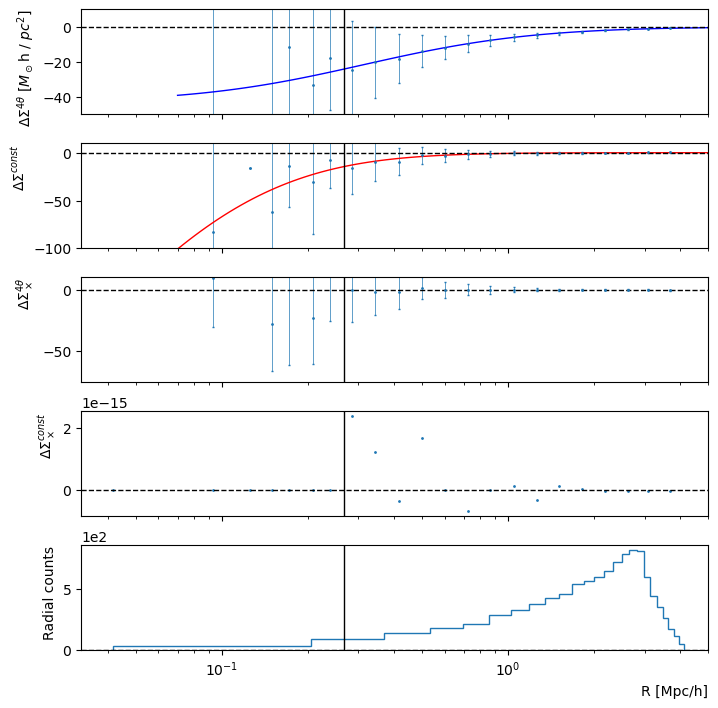

In [138]:
fig, axs = plt.subplots(5,1, figsize=(7,7), sharex=True);
plt.ticklabel_format(style='sci', axis='y', scilimits=(-2,2))
plt.tight_layout();

## Delta Sigma 4theta
axs[0].errorbar(r_bins, np.array(delta_sigmas_4theta)[:,0] / 0.7 / 1e12, yerr=np.array(delta_sigmas_4theta)[:,1] / 0.7 / 1e12, fmt='o', markersize=1, ls='none', elinewidth=0.5, capsize=1);
axs[0].plot(r_, ds4theta/0.7 / 1e12, 'b-', lw=1);
axs[0].set_ylabel(r'$\Delta \Sigma^{4\theta}$ [$M_\odot$h / $pc^2$]', loc='top');
axs[0].set_xscale('log');
axs[0].set_ylim(-50, 10);
axs[0].axhline(0, lw=1, ls='--', c='k');
axs[0].axvline(rs, lw=1, ls='-', c='k');

## Delta Sigma const
axs[1].errorbar(r_bins, np.array(delta_sigmas_const)[:,0] / 0.7 / 1e12, yerr=np.array(delta_sigmas_const)[:,1] / 0.7 / 1e12, fmt='o', markersize=1, ls='none', elinewidth=0.5, capsize=1);
axs[1].plot(r_, dsconst/0.7 / 1e12, 'r-', lw=1)
axs[1].set_ylabel(r'$\Delta \Sigma^{const}$', loc='top');
axs[1].set_xscale('log');
axs[1].set_ylim(-100, 10);
axs[1].axhline(0, lw=1, ls='--', c='k');
axs[1].axvline(rs, lw=1, ls='-', c='k');

## Delta Sigma 4theta X
axs[2].errorbar(r_bins, np.array(delta_sigmas_4theta_cross)[:,0] / 0.7 / 1e12, yerr=np.array(delta_sigmas_4theta_cross)[:,1] / 0.7 / 1e12, fmt='o', markersize=1, ls='none', elinewidth=0.5, capsize=1);
axs[2].set_ylabel(r'$\Delta \Sigma^{4\theta}_\times$', loc='top');
axs[2].set_xscale('log');
axs[2].set_ylim(top=10);
axs[2].axhline(0, lw=1, ls='--', c='k');
axs[2].axvline(rs, lw=1, ls='-', c='k');

## Delta Sigma const X
axs[3].scatter(r_bins, np.array(delta_sigmas_const_cross)[:,0] / 0.7 / 1e12, s=1);
axs[3].set_ylabel(r'$\Delta \Sigma^{const}_\times$', loc='top');
axs[3].set_xscale('log');
axs[3].axhline(0, lw=1, ls='--', c='k');
axs[3].axvline(rs, lw=1, ls='-', c='k');

axs[4].hist(r, bins=Nbins, histtype='step');
axs[4].axhline(0, lw=1, ls='--', c='k');
axs[4].axvline(rs, lw=1, ls='-', c='k');
axs[4].set_ylabel('Radial counts', loc='top');
axs[4].set_xlabel('R [Mpc/h]', loc='right');
axs[4].set_xlim(right=5);

## Calculate monopole term

In [54]:
from scipy.stats import binned_statistic

In [158]:
gammat_mono = -2*binned_statistic(r, gamma1*np.cos(2*theta), statistic='mean', bins=rbin_edges)[0]

In [152]:
DS_model = _delta_sigma_excess(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000, delta_mdef=200)

In [153]:
eta_0_arr = np.gradient(np.log(DS_model),r)*r


/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/numpy/lib/function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/numpy/lib/function_base.py:1248: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


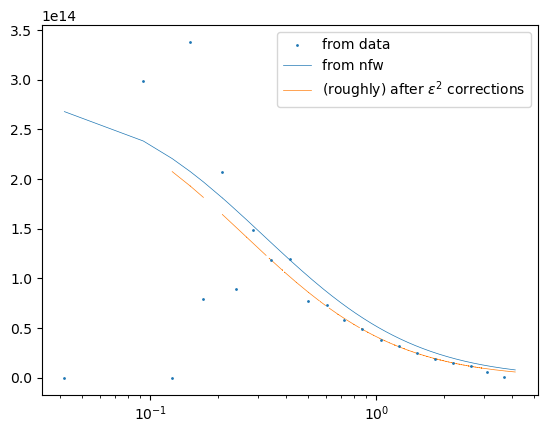

In [169]:
r_order = np.argsort(r)
plt.scatter(r_bins, gammat_mono*sigma_crit, s=1, label='from data', zorder=np.inf);
plt.plot(r[r_order], DS_model[r_order], lw=0.5, label='from nfw');
plt.plot(r[r_order], DS_model[r_order]/q**(eta_0_arr[r_order]/2), lw=0.5, label='(roughly) after $\epsilon^2$ corrections');
plt.xscale('log');
plt.legend();

## Implementing emcee

In [172]:
def log_prior(theta):
    ell_, log_mdelta, cdelta, log_f1, log_f2 = theta
    if (0 <= ell <= 1) and (12 <= log_mdelta <= 18) and (1 <= cdelta <= 20) and (-10 <= log_f1 <= 0) and (-10 <= log_f2 <= 0) :
        return 0.0
    return -np.inf

In [173]:
def log_probability(theta, x, y1, dy1, y2, dy2) :
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + MLE(theta, x, y1, dy1, y2, dy2)

In [181]:
import emcee

pos = results.x + 1e-4 * np.random.randn(32, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(r_bins[order], np.array(delta_sigmas_4theta)[:,0][order], np.array(delta_sigmas_4theta)[:,1][order], np.array(delta_sigmas_const)[:,0][order], np.array(delta_sigmas_const)[:,1][order]))
sampler.run_mcmc(pos, 10000, progress=True);

 62%|██████▏   | 6210/10000 [09:22<05:26, 11.60it/s]/pbs/throng/lsst/users/rsolomon/CLMM/examples/triaxiality/model_functions.py:54: RuntimeWarning: invalid value encountered in log
  eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr
/pbs/throng/lsst/users/rsolomon/CLMM/examples/triaxiality/model_functions.py:79: RuntimeWarning: invalid value encountered in log
  eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr
 62%|██████▏   | 6211/10000 [09:22<05:43, 11.04it/s]


ValueError: Probability function returned NaN

In [176]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [218.10571646  79.36641045 622.46162435 100.11245187 198.74132902]

In [177]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 5)


In [180]:
import corner

fig = corner.corner(flat_samples);

SystemError: initialization of _internal failed without raising an exception